# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a simulated GRB.

Simulations: The GRB was simulated using MEGAlib with the RelativeX polarization convention and combined with all Data Challenge 2 background components. The start time, duration, sky position, and spectrum of the GRB are assumed to already be known, and the unpolarized and 100% polarized simulations were created using this information. The GRB was simulated with 70% polarization at an angle of 110 degrees, and the background is unpolarized. The 100% polarized simulation was created with 100% polarization at an angle of 0 degrees.

The data to run this notebook (on-axis, 10 degrees off-axis, and 20 degrees off-axis GRBs) can be found on the COSI Pipeline Google Drive: https://drive.google.com/drive/folders/1kCkqQv07APSSlexeuIgK2Jj7eqJzNNgQ

Caveats/limitations:
- Currently, the source must be stationary with respect to the instrument, and the spacecraft must be stationary. The ability to fit the polarization of persistent sources will be added later. 
- The background simulation is used as the background model, and its ASAD is subtracted from the source+background ASAD.   
- The 100% polarized simulation was created with an arbitrary polarization angle. For the COSI balloon, the modulation factor was constant with respect to the polarization angle, so this probably isn't affecting things too much, but should be fixed in future simulations.

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization import PolarizationASAD, calculate_uncertainties
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame

Welcome to JupyROOT 6.28/02


22:31:43 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=353583;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=440547;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=171848;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=710238;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=96626;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=376544;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=622280;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=114839;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=814949;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=269643;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=324019;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=836566;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=452652;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=785115;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

22:31:43 WARNING   Multinest minimizer not available                                           ]8;id=950095;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=474533;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=295539;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=268318;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=872672;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=68688;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=550057;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=866027;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=72867;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=398858;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

22:31:44 WARNING   No fermitools installed                                              ]8;id=795571;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=153369;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

22:31:44 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=280449;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=197371;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=907196;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=574210;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=794066;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=501899;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

### Read in unbinned data     
Read in the data (GRB+background), 100% polarized and unpolarized simulations, and background simulation

In [2]:
analysis = UnBinnedData('/path/to/yaml/file') # e.g. grb.yaml

analysis.select_data(unbinned_data='/path/to/data/file', output_name='/path/to/selected/data/file') # e.g. GRB_0_0.hdf5 & GRB_0_0_selected.hdf5
data = analysis.get_dict_from_hdf5('/path/to/selected/data/file') # e.g. GRB_0_0_selected.hdf5
data_polarized = analysis.get_dict_from_hdf5('/path/to/polarized/data/file') # e.g. GRB-polarized_0_0.hdf5
data_unpolarized = analysis.get_dict_from_hdf5('/path/to/unpolarized/data/file') # e.g. GRB-unpolarized_0_0.hdf5
background = analysis.get_dict_from_hdf5('/path/to/background/file') # e.g. background.hdf5

Read in the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin

In [3]:
sc_orientation = SpacecraftFile.parse_from_file('/path/to/ori/file') # e.g. ori.ori

attitude = sc_orientation.get_attitude()[0]

Define the source position and polarization convention. This needs to be changed depending on the dataset you're using (azimuth=0 & zenith=90 for the on-axis GRB, azimuth=0 & zenith=80 for the 10 degrees off-axis GRB, and azimuth=0 & zenith=70 for the 20 degrees off-axis GRB)

In [4]:
source_direction = SkyCoord(0, 90, representation_type='spherical', frame=SpacecraftFrame(attitude=attitude), unit=u.deg)

grb_polarization = PolarizationASAD(source_direction)

Calculate the azimuthal scattering angle for each photon in the data, 100% polarized and unpolarized simulations, and background simulation

In [6]:
data_dict = {'grb & background': data, 'background': background, 'polarized': data_polarized, 'unpolarized': data_unpolarized}
azimuthal_angles = {}

for key in data_dict.keys():
    azimuthal_angles[key] = grb_polarization.calculate_azimuthal_scattering_angles(data_dict[key])

Create an azimuthal scattering angle distribution (ASAD) each for the data, 100% polarized and unpolarized simulations, and background simulation

In [7]:
bin_edges = Angle(np.linspace(-np.pi, np.pi, 18), unit=u.rad) # Define ASAD bins

asads = {}
for key in azimuthal_angles.keys():
    asads[key] = grb_polarization.create_asad(azimuthal_angles[key], bin_edges)

Calculate the ASAD of the GRB only by subtracting the background ASAD from the GRB+background ASAD

In [8]:
source_duration = analysis.tmax - analysis.tmin # Duration of GRB simulation
background_duration = np.max(background['TimeTags']) - np.min(background['TimeTags']) # Duration of background simulation

background_asad_grb_duration = (asads['background']['counts'] * source_duration / background_duration).astype(int)
grb_asad = asads['grb & background']['counts'] - background_asad_grb_duration

asads['grb'] = {'counts': grb_asad, 'uncertainties': calculate_uncertainties(grb_asad)}

Plot the ASADs

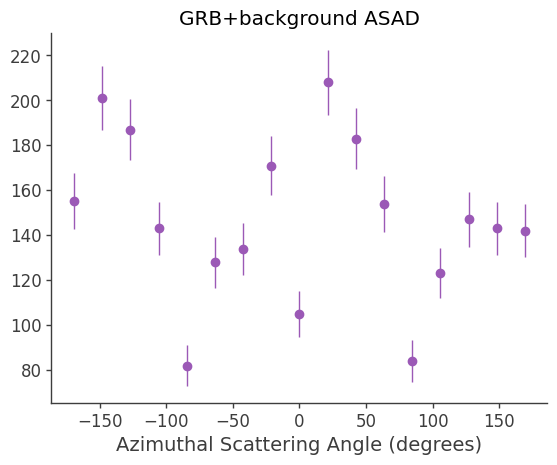

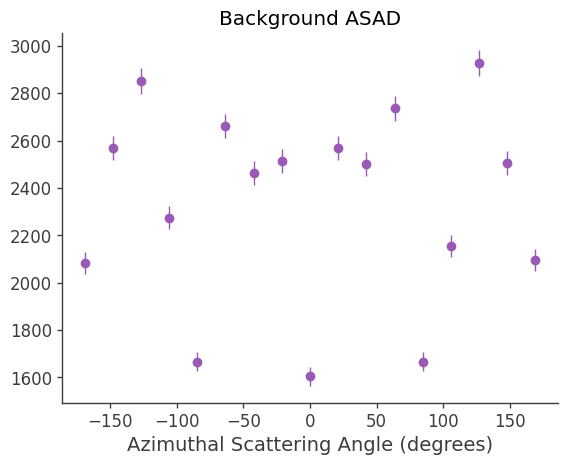

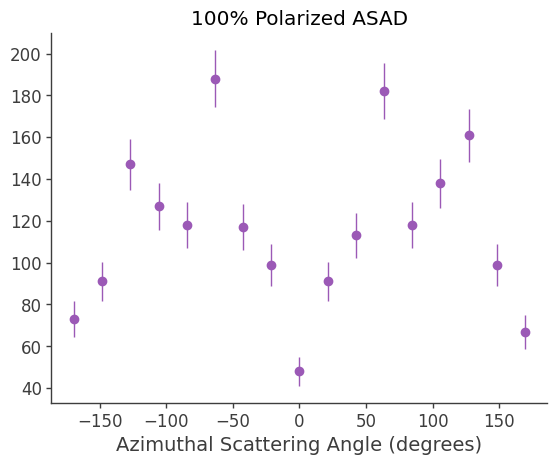

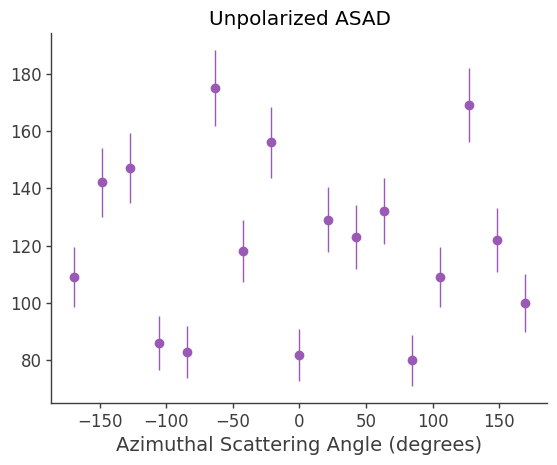

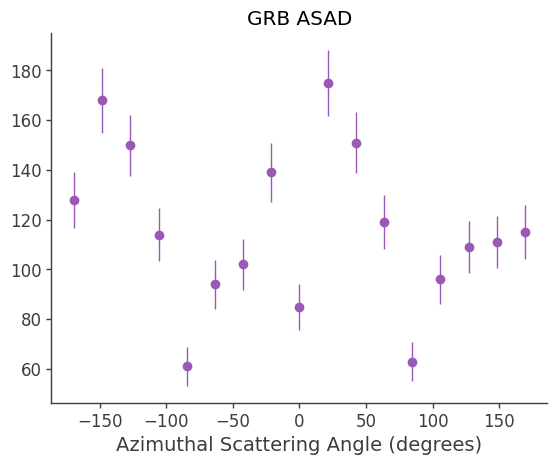

In [9]:
titles = {'grb': 'GRB ASAD', 'grb & background': 'GRB+background ASAD', 'background': 'Background ASAD', 'polarized': '100% Polarized ASAD', 'unpolarized': 'Unpolarized ASAD'}
for key in asads.keys():
    grb_polarization.plot_asad(asads[key]['counts'], asads[key]['uncertainties'], titles[key])

Divide the GRB & 100% polarized ASADs by the unpolarized ASAD to correct for instrumental effects

In [10]:
asads_corrected = {}
for key in ['grb', 'polarized']:
    asads_corrected[key] = grb_polarization.correct_asad(asads[key], asads['unpolarized'])

Calculate the modulation of a 100% polarized source and minimum detectable polarization (MDP)  

In [11]:
mu_100 = grb_polarization.calculate_mu(asads_corrected['polarized']['counts'], bounds=([0, 0, 0], [np.inf,np.inf,np.pi]), sigma=asads_corrected['polarized']['uncertainties'])

source_counts = {'grb': np.sum(asads['grb']['counts']), 'polarized': np.sum(asads['polarized']['counts'])}
background_counts = {'grb': np.sum(background_asad_grb_duration), 'polarized': 0}
mdps = {}

for key in ['grb', 'polarized']:
    mdps[key] = 4.29 / mu_100['mu'] * np.sqrt(source_counts[key] + background_counts[key]) / source_counts[key]

Modulation: 0.398 +/- 0.041


Fit the polarization fraction and angle of the GRB and 100% polarized simulation   

In [12]:
polarizations = {}
for key in ['grb', 'polarized']:
    print(key + ':')
    polarizations[key] = grb_polarization.fit(mu_100, asads_corrected[key]['counts'], bounds=([0, 0, 0], [np.inf,np.inf,np.pi]), sigma=asads_corrected[key]['uncertainties'])

    if mdps[key] > polarizations[key]['fraction']:
        print('Polarization fraction is below MDP!', 'MDP:', round(mdps[key], 3), '\n')
    else:
        print('MDP:', round(mdps[key], 3), '\n')

grb:
Best fit polarization fraction: 0.785 +/- 0.144
Best fit polarization angle: 85.959 +/- 4.55
MDP: 0.271 

polarized:
Best fit polarization fraction: 1.0 +/- 0.147
Best fit polarization angle: 151.547 +/- 2.415
MDP: 0.242 



Plot the corrected ASADs for the GRB & 100% polarized simulation with the best fit sinusoidal function

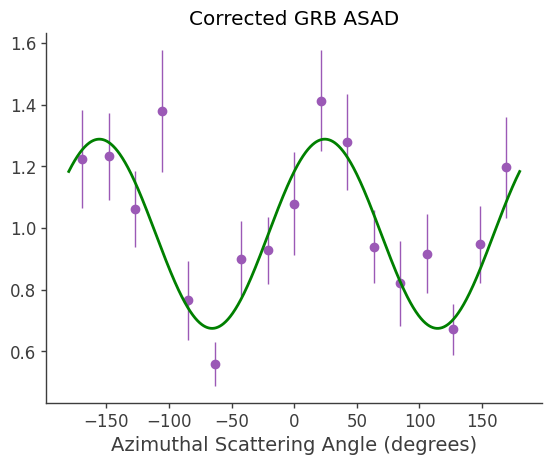

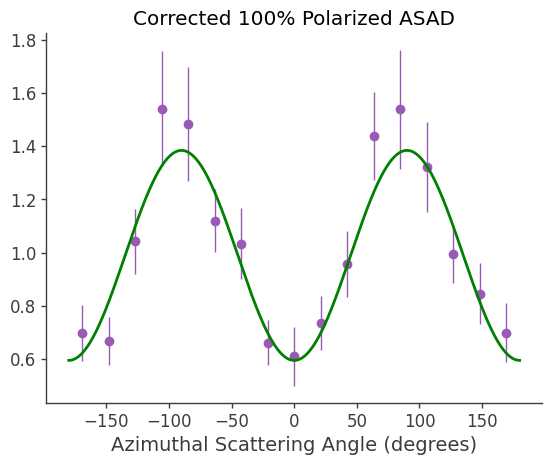

In [13]:
for key in ['grb', 'polarized']:
    grb_polarization.plot_asad(asads_corrected[key]['counts'], asads_corrected[key]['uncertainties'], 'Corrected ' + titles[key], coefficients=polarizations[key]['best fit parameter values'])

Transform polarization angle to different conventions

In [14]:
print('RelativeX:', round(polarizations['grb']['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarizations['grb']['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarizations['grb']['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarizations['grb']['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')

RelativeX: 114.412 degrees
RelativeY: 24.412 degrees
RelativeZ: nan degrees
IAU: 85.959 degrees



WARNING RuntimeWarning: invalid value encountered in divide

